In [14]:
### Import & setup
import os
import sys
sys.path.append('C:\\Users\\szb37\\My Drive\\Projects\\ADAPT\\ADAPT codebase\\')
import src.folders as folders
import src.power as power
import src.config as config
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportion_confint
import src.config as config
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 300  # Set display DPI
plt.style.use('seaborn-v0_8-notebook')  # notebook-optimized

def save_fig(fig, fname):
    for format in ['png', 'svg']:
        fig.savefig(
            fname=os.path.join(folders.powerplots, f'{fname}.{format}'),
            bbox_inches='tight',
            format=format,
            dpi=300,)

### Parameters
prefix = 'mock'
n_trials = 500
sample = 300
samples = np.arange(20, 110, 10).tolist() + np.arange(120, 320, 20).tolist()

# Real-world CGR unmasking vs. effiacy

In [3]:
### Generate outcome data based on params from RL studies
scenario_params = []
scenario_params.append(
    ('Goodwin SMD 0.8', 
    {'type': 'normal',
        'arm_params':{
            'C': {'mean': 1, 'sd': 1,},
            'T': {'mean': 1.8, 'sd': 1,},},}))
scenario_params.append(
    ('Raison SMD 1.2', 
    {'type': 'normal',
        'arm_params':{
            'C': {'mean': 1, 'sd': 1,},
            'T': {'mean': 2.2, 'sd': 1,},},}))
scenario_params.append(
    ('Carhart-H. SMD 1.3', 
    {'type': 'normal',
        'arm_params':{
            'C': {'mean': 1, 'sd': 1,},
            'T': {'mean': 2.3, 'sd': 1,},},}))

df_patientsData=[]
for scenario_param in scenario_params:
    scenario = scenario_param[0]
    params = scenario_param[1]
    df_patientData = power.DataGeneration.get_df_patientsData(
        scenario = scenario, 
        n_trials = n_trials, 
        sample = sample, 
        params = [params])
    df_patientsData.append(df_patientData)                
df_outcome_patientsData = pd.concat(df_patientsData, ignore_index=True)

### Calculate OUTCOME CIs
df_outcomeCIs = power.Stats.get_df_diffCIs_vector(
    df_outcome_patientsData, 
    samples = samples)
df_outcomeCIs = df_outcomeCIs.rename(columns={
    'ciL': 'gmg_ciL',    
    'ciH': 'gmg_ciH', 
    'moe': 'gmg_moe',})    
df_outcomeCIs = power.Stats.add_sigdiff(df_outcomeCIs)

In [10]:
### Generate blinding data based on params from RL studies; sample CGR CI
scenarios = []
ciL, ciH = proportion_confint(89, 95) # Bogenschutz
scenarios.append(('Bogenschutz (CGR: 0.94)', (ciL, ciH)))
ciL, ciH = proportion_confint(20, 24) # POP
scenarios.append(('POP (CGR: 0.83)', (ciL, ciH)))
ciL, ciH = proportion_confint(34, 37) # Rieser
scenarios.append(('Rieser (CGR: 0.92)', (ciL, ciH)))

df_patientsData = []
for scenario in scenarios:
    scenario_name = scenario[0]
    ciL = round(scenario[1][0], 3)
    ciH = round(scenario[1][1], 3)
    
    for tID in np.arange(0, n_trials, 1):

        cgr = round(np.random.uniform(low=ciL, high=ciH), 3)
        scenario = f'{scenario_name}'
        params = {
            'type': 'binaryguess',
            'arm_params':{
                'C': {'cgr': cgr},
                'T': {'cgr': cgr},},}

        df = power.DataGeneration.get_df_patientsData(
            scenario = scenario, 
            n_trials = 1, 
            sample = sample, 
            params = [params])
        df['trial'] = tID
        df_patientsData.append(df)
df_patientsData = pd.concat(df_patientsData, ignore_index=True)

### Calculate CGR CIs
df_cgrCIs = power.Stats.get_df_cgrCIs_vector(
    df_patientsData, 
    samples = samples)
df_cgrCIs = df_cgrCIs.rename(columns={
    'ciL': 'cgr_ciL',    
    'ciH': 'cgr_ciH', 
    'moe': 'cgr_moe',})    
df_cgrCIs = power.Stats.add_sigdiff(df_cgrCIs)

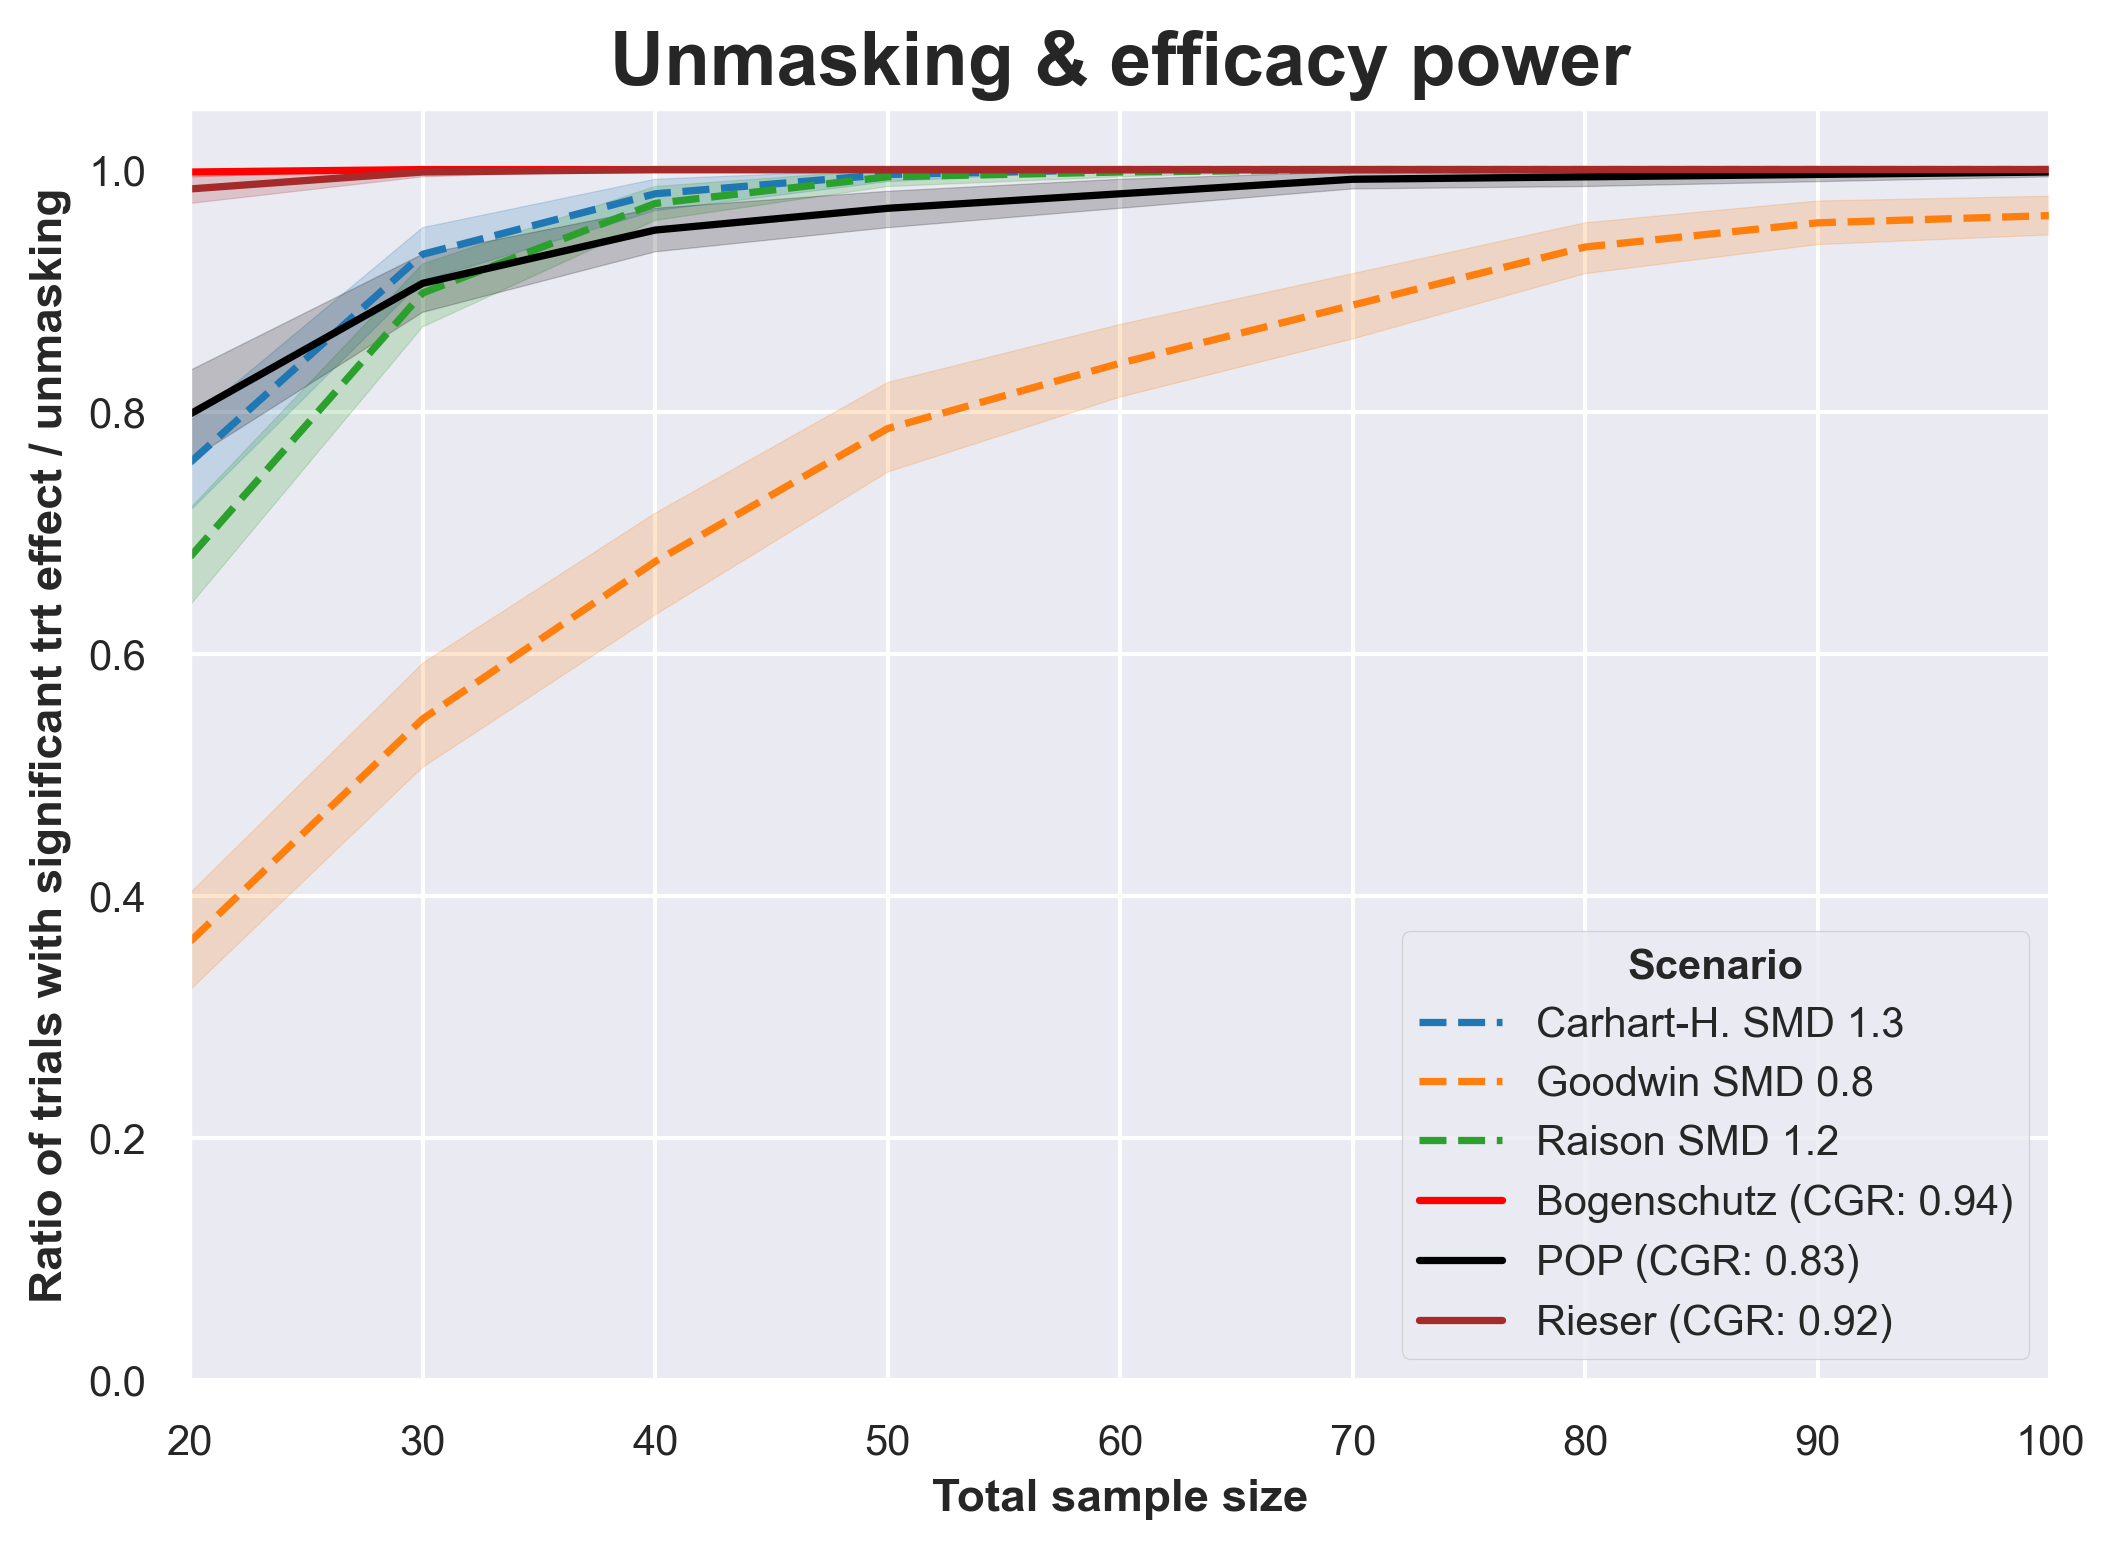

In [11]:
### Unmasking (CGR) & efficacy power plot 
fig, ax = plt.subplots()
sns.lineplot(
    data = df_outcomeCIs,
    x = 'sample', 
    y = 'gmg_sd',
    hue = 'scenario',
    linestyle = '--',)

sns.lineplot(
    data = df_cgrCIs,
    x = 'sample', 
    y = 'cgr_sd',
    palette = ['red', 'black', 'brown'],
    hue = 'scenario',)

plt.title('Unmasking & efficacy power', fontweight='bold', fontsize=18)
ax.set_xlabel('Total sample size', fontweight='bold')
ax.set_ylabel('Ratio of trials with significant trt effect / unmasking', fontweight='bold')
ax.set_xlim([df_outcomeCIs['sample'].min(), 100]) # df_outcomeCIs['sample'].max()])
ax.set_ylim([0, 1.05])
plt.legend(
    title='Scenario', 
    title_fontproperties = {'weight': 'bold'},
    loc='lower right')

#save_fig(fig, 'power_mixed_studies')
plt.show()

# Real-world GMG unmasking vs. effiacy

In [13]:
prefix = 'mock'
n_trials = 5
sample = 10

### Generate GMG guess data with confidences
df_patientsData=[]
for diff in np.arange(0, 6, 5):
    scenario = f'Δ guess {diff}mg'
    params = {
        'type': 'normal',
        'arm_params':{
            'C': {'mean': (10.5 - diff/2), 'sd': 7.6,},
            'T': {'mean': (10.5 + diff/2), 'sd': 7.6,},},}

    df = power.DataGeneration.get_df_patientsData(
        scenario = scenario, 
        n_trials = n_trials, 
        sample = sample, 
        params = [params])
    df_patientsData.append(df)

# Concatanate dfs, rename, clip
df_patientsData = pd.concat(df_patientsData, ignore_index=True)
df_patientsData = df_patientsData.rename(columns={'value': 'gmg'})
df_patientsData['gmg'] = df_patientsData['gmg'].round(1)
df_patientsData['gmg'] = df_patientsData['gmg'].clip(lower=0, upper=30)

# Add confidence & corresponding SEs
df_patientsData['conf'] = np.random.choice(config.confs, size=df_patientsData.shape[0]) 
df_patientsData['gmg_sd'] = df_patientsData['conf'].map(config.conf_to_se) # Since each patient is unique, SD = SE

### Calc combined mean and SD for each scenario, trt - i.e. avg across trials
scenarios = df_patientsData.scenario.unique()
trts = df_patientsData.trt.unique()

rows=[]
for scenario, trt in product(scenarios, trts):

    df_tmp = df_patientsData.loc[
        (df_patientsData.scenario==scenario) & 
        (df_patientsData.trt==trt)]

    row = {}
    row['scenario'] = scenario
    row['trt'] = trt
    row['comb_gmg'] = df_tmp['gmg'].mean()
    comb_gmg_sd = np.sqrt((df_tmp['gmg_sd']**2).mean())
    row['comb_gmg_sd'] = comb_gmg_sd
    rows.append(row)
df_combined_gmgs = pd.DataFrame(rows)




NameError: name 'config' is not defined